In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading the model
from scipy.stats import chisquare, pearsonr, linregress
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr

In [3]:
# Read the manipulated dataset
df = pd.read_csv("My_mpg_manipulated.csv")  # From Tuvshin manipulated data
mpg = df['mpg'].dropna().values 
hp = df['hp'].dropna().values

original_df = pd.read_csv("mtcars_original.csv")
original_mpg = original_df['mpg']
original_hp = original_df['hp']

Correlation coefficient: 0.892
P-value: 7.108e-12


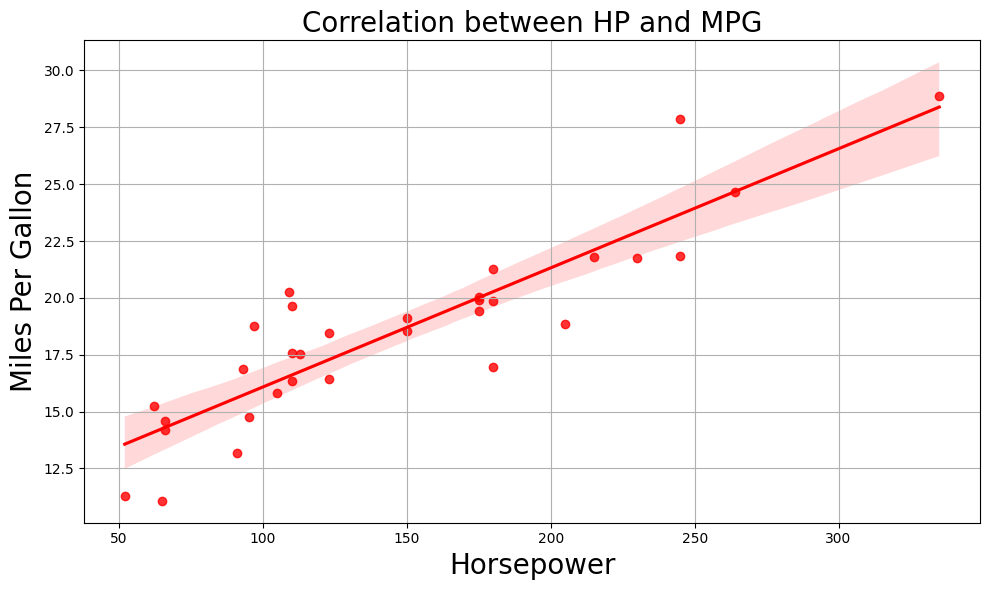

In [3]:
#Analyze my manipulated dataset

# Load CSV file
dfM = pd.read_csv("My_mpg_manipulated.csv")  # My manipulated data

# Extract variables
xm = dfM['hp']
ym = dfM['mpg']

# Compute Pearson correlation and p-value
corr_coeff, p_value = pearsonr(xm, ym)
print(f"Correlation coefficient: {corr_coeff:.3f}")
print(f"P-value: {p_value:.3e}")

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x=xm, y=ym, scatter_kws={'color': 'red'}, line_kws={'color': 'red'})
plt.title("Correlation between HP and MPG", fontsize=20)
plt.xlabel("Horsepower", fontsize=20)
plt.ylabel("Miles Per Gallon", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Benford expected distribution
def benford_distribution():
    return np.array([np.log10(1 + 1/d) for d in range(1, 10)])

# Extract first digit from numeric array
def extract_first_digit(array):
    first_digits = []
    for val in array:
        val_str = str(abs(val)).replace('.', '')
        if val_str and val_str[0].isdigit():
            first_digits.append(int(val_str[0]))
    return first_digits

# === Extract first digit from numeric array ===
def extract_first_digits(data):
    data = pd.Series(data).dropna()
    first_digits = data.astype(str).str.replace('.', '', regex=False).str.strip().str[0]
    return first_digits.astype(int)

# === Calculate Benford statistics: Chi-square, p-value, Euclidean Distance ===
def benford_stats(data):
    first_digits = extract_first_digits(data)
    observed_counts = first_digits.value_counts().sort_index()
    observed = observed_counts.reindex(range(1, 10), fill_value=0).values
    expected = benford_distribution() * observed.sum()

    chi2, pval = chisquare(f_obs=observed, f_exp=expected)
    euclidean_dist = np.linalg.norm(observed / observed.sum() - benford_distribution())

    return chi2, pval, euclidean_dist

def synthesize_benford_mpg(n_samples=1000, min_val=15, max_val=40, noise_std=0.1, seed=2):
    np.random.seed(seed)  # Set the seed for reproducibility
    samples = []
    while len(samples) < n_samples:
        digit = np.random.choice(benford_digits, p=benford_probs)
        exponent = np.random.uniform(1.3, 1.5)  # Control scale
        noise = np.random.normal(0, noise_std)
        value = digit * 10 ** exponent + noise
        if min_val <= value <= max_val:
            samples.append(value)
    return np.array(samples[:n_samples]) 

# --- Reverse predicted_mpg using the same logic ---
def reverse_predictions(y_pred, noise_std=2.3, seed=5):
    np.random.seed(seed)
    
    y_mean = np.mean(y_pred)
    y_inv = 2 * y_mean - y_pred  # mirror around mean
    noise = np.random.normal(0, noise_std, size=y_pred.shape)
    
    # Clip to original prediction range
    y_inv_noisy = np.clip(y_inv + noise, y_pred.min(), y_pred.max())
    return y_inv_noisy


In [6]:
# --- Benford distribution ---
benford_probs = np.array([np.log10(1 + 1/d) for d in range(1, 10)])
benford_digits = np.arange(1, 10)


# Reconstructed
Benford_mpg = synthesize_benford_mpg(n_samples=len(hp))

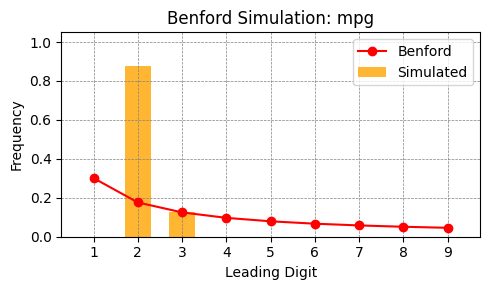

In [7]:
# Get observed frequencies
first_digits = extract_first_digit(Benford_mpg)
observed_counts = pd.Series(first_digits).value_counts().sort_index()
observed_freq = observed_counts.reindex(range(1, 10), fill_value=0) / len(first_digits)

# Calculate stats
chi2S, pvalS, eu_distS = benford_stats(Benford_mpg)

# Plot Benford vs Observed
plt.figure(figsize=(5, 3))
plt.bar(observed_freq.index, observed_freq.values, width=0.6, color='orange', alpha=0.8, label='Simulated')
plt.plot(range(1, 10), benford_distribution(), 'ro-', label="Benford")
plt.xlabel("Leading Digit")
plt.ylabel("Frequency")
plt.title("Benford Simulation: mpg")
plt.xticks(range(1, 10))
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

In [18]:

# Read the manipulated dataset
#df = pd.read_csv("mtcars_original.csv")  
#mpg = df['mpg'].dropna().values 
#hp = df['hp'].dropna().values

#original_df = pd.read_csv("mtcars_original.csv")
#original_mpg = original_df['mpg']
#original_hp = original_df['hp']

manipulated = pd.read_csv("mtcars_original.csv")
features = ['hp'] 
target = 'mpg'


X_test = manipulated[features]
model = joblib.load("myRegressionmodelOriginal.pkl")
predicted_mpg = model.predict(X_test)
# Apply to predicted_mpg
#reversed_predicted_mpg = reverse_predictions(predicted_mpg, noise_std=2.3, seed=5)

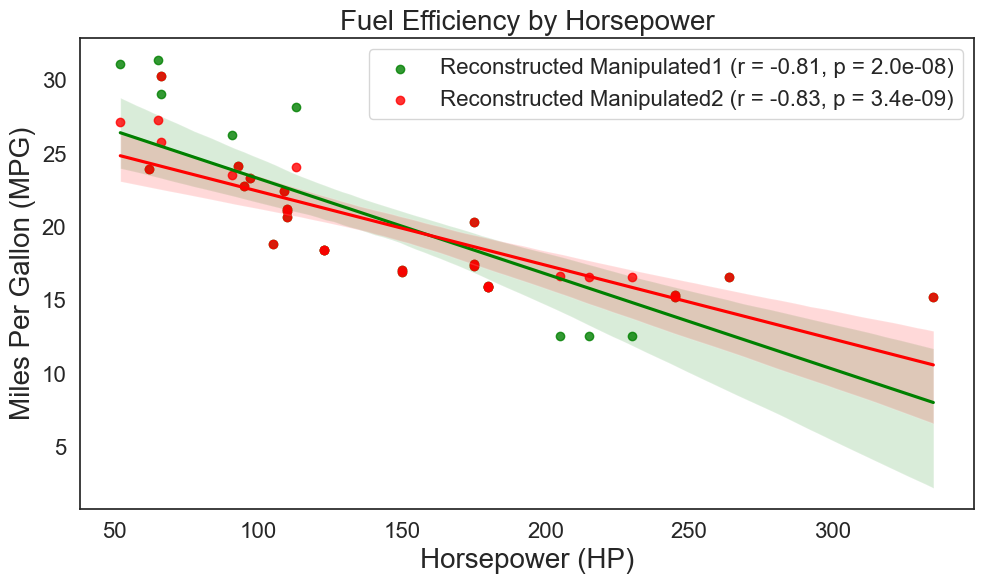

In [10]:


# Load original data
df_original = pd.read_csv("mtcars_original.csv")
df_manipulated = pd.read_csv("My_mpg_manipulated.csv")  # Use correct manipulated file

# Feature and target columns
features = ['hp', 'wt', 'disp', 'cyl']
target = 'mpg'

# Prepare features for prediction
X_original = df_original[features]
X_manipulated = df_manipulated[features]

# Load trained regression model
model = joblib.load("myRegressionmodelOriginal.pkl")

# Predict MPG using the model
predicted_mpg_original = model.predict(X_original)
predicted_mpg_manipulated = model.predict(X_manipulated)

# Compute Pearson correlation between 'hp' and predicted MPG
r_original, p_original = pearsonr(df_original['hp'], predicted_mpg_original)
r_manipulated, p_manipulated = pearsonr(df_manipulated['hp'], predicted_mpg_manipulated)

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="white")

# Original data plot
sns.regplot(
    x=df_original['hp'],
    y=predicted_mpg_original,
    scatter=True,
    color="green",
    line_kws={'color': 'green'},
    label=f"Reconstructed Manipulated1 (r = {r_original:.2f}, p = {p_original:.1e})"
)

# Manipulated data plot
sns.regplot(
    x=df_manipulated['hp'],
    y=predicted_mpg_manipulated,
    scatter=True,
    color="red",
    line_kws={'color': 'red'},
    label=f"Reconstructed Manipulated2 (r = {r_manipulated:.2f}, p = {p_manipulated:.1e})"
)

# Formatting
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Horsepower (HP)", fontsize=20)
plt.ylabel("Miles Per Gallon (MPG)", fontsize=20)
plt.title("Fuel Efficiency by Horsepower", fontsize=20)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


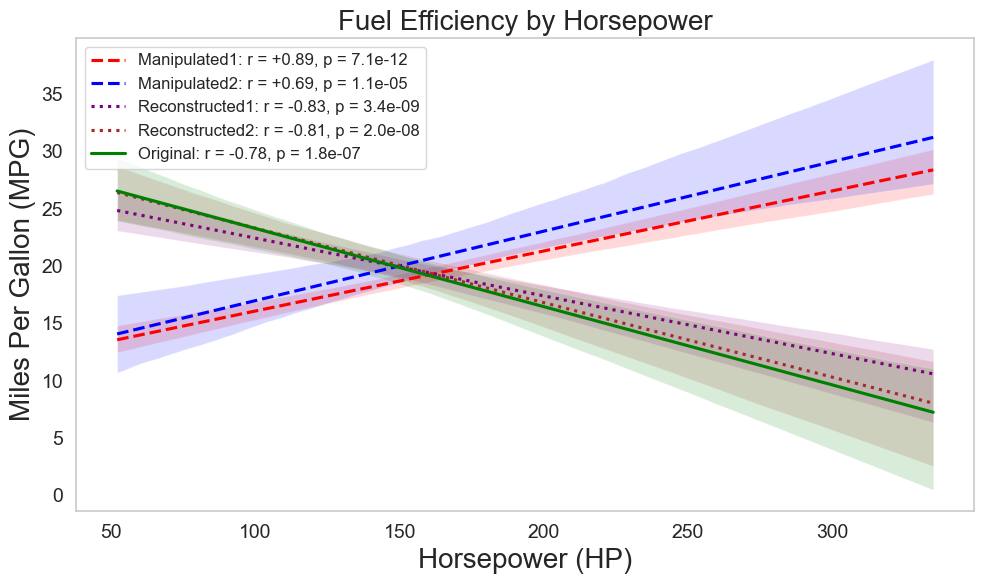

In [21]:

# -----------------------------
# Load Data
# -----------------------------
df_original = pd.read_csv("mtcars_original.csv")
df_manip1 = pd.read_csv("My_mpg_manipulated.csv")
df_manip2 = pd.read_csv("My_mpg_manipulated_r07.csv")  # Correct file for second manipulated set

# -----------------------------
# Define Features and Target
# -----------------------------
features = ['hp', 'wt', 'disp', 'cyl']
target = 'mpg'

# Ensure consistency of features across datasets
X_original = df_original[features].copy()
X_manip1 = df_manip1[features].copy()
X_manip2 = df_manip2[features].copy()

# -----------------------------
# Load Pretrained Model
# -----------------------------
model = joblib.load("myRegressionmodelOriginal.pkl")

# Optional: Ensure feature match
assert list(model.feature_names_in_) == features, "Feature mismatch with model"

# -----------------------------
# Make Predictions
# -----------------------------
pred_orig = model.predict(X_original)
pred_manip1 = model.predict(X_manip1)
pred_manip2 = model.predict(X_manip2)

# -----------------------------
# Compute Pearson Correlations
# -----------------------------
corr = {
    "manip1_true": pearsonr(df_manip1['hp'], df_manip1['mpg']),
    "manip2_true": pearsonr(df_manip2['hp'], df_manip2['mpg']),
    "manip1_pred": pearsonr(df_manip1['hp'], pred_manip1),
    "manip2_pred": pearsonr(df_manip2['hp'], pred_manip2),
    "original_true": pearsonr(df_original['hp'], df_original['mpg']),
    "original_pred": pearsonr(df_original['hp'], pred_orig),
}

# -----------------------------
# Plot Regression Lines
# -----------------------------
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.grid(False)

# Manipulated datasets
sns.regplot(x='hp', y='mpg', data=df_manip1, scatter=False,
            line_kws={'color': 'red', 'linestyle': '--'},
            label=f"Manipulated1: r = +{corr['manip1_true'][0]:.2f}, p = {corr['manip1_true'][1]:.1e}")
sns.regplot(x='hp', y='mpg', data=df_manip2, scatter=False,
            line_kws={'color': 'blue', 'linestyle': '--'},
            label=f"Manipulated2: r = +{corr['manip2_true'][0]:.2f}, p = {corr['manip2_true'][1]:.1e}")

# Reconstructed (predicted) datasets
sns.regplot(x=df_manip1['hp'], y=pred_manip1, scatter=False,
            line_kws={'color': 'purple', 'linestyle': ':'},
            label=f"Reconstructed1: r = {corr['manip1_pred'][0]:.2f}, p = {corr['manip1_pred'][1]:.1e}")
sns.regplot(x=df_manip2['hp'], y=pred_manip2, scatter=False,
            line_kws={'color': 'brown', 'linestyle': ':'},
            label=f"Reconstructed2: r = {corr['manip2_pred'][0]:.2f}, p = {corr['manip2_pred'][1]:.1e}")
#sns.regplot(x=df_original['hp'], y=pred_orig, scatter=False,
            #line_kws={'color': 'cyan', 'linestyle': '--'},
            #label=f"Reconstructed0: r = {corr['original_pred'][0]:.2f}, p = {corr['original_pred'][1]:.1e}")

# Original data
sns.regplot(x='hp', y='mpg', data=df_original, scatter=False,
            line_kws={'color': 'green'},
            label=f"Original: r = {corr['original_true'][0]:.2f}, p = {corr['original_true'][1]:.1e}")

# -----------------------------
# Plot Formatting
# -----------------------------
plt.xlabel("Horsepower (HP)", fontsize=20)
plt.ylabel("Miles Per Gallon (MPG)", fontsize=20)
plt.title("Fuel Efficiency by Horsepower", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [7]:


# Load original and manipulated data
df_original = pd.read_csv("mtcars_original.csv")
df_manipulated = pd.read_csv("My_mpg_manipulated.csv")

# Define features and target
features = ['hp', 'wt', 'disp', 'cyl']
target = 'mpg'

# Prepare features for prediction
X_manipulated = df_manipulated[features]

# Load trained regression model
model = joblib.load("myRegressionmodelOriginal.pkl")

# Predict MPG using the model
predicted_mpg_manipulated = model.predict(X_manipulated)

# Calculate correlation coefficient and p-value
r0, p0 = pearsonr(df_original['hp'], df_original[target])
print(f"Correlation (r0) between HP and origina; MPG: {r0:.3f}")
print(f"P-value: {p0:.5e}")

# Calculate correlation coefficient and p-value
r, p = pearsonr(df_manipulated['hp'], predicted_mpg_manipulated)
print(f"Correlation (r) between HP and predicted MPG: {r:.3f}")
print(f"P-value: {p:.5e}")

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="white")

# Plot predicted MPG in red
sns.regplot(x=df_manipulated['hp'], y=predicted_mpg_manipulated, scatter=True, color='red', line_kws={'color': 'red', 'alpha': 0.4})

# Plot original MPG in green
sns.regplot(x=df_original['hp'], y=df_original[target], scatter=True, color='green', line_kws={'color': 'green','alpha': 0.4})

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Horsepower (HP)", fontsize=20)
plt.ylabel("Miles Per Gallon (MPG)", fontsize=20)
plt.title("Fuel Efficiency by Horsepower", fontsize=20)

plt.tight_layout()
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- cyl
- disp


Dataset: My_mpg_manipulated.csv
  Correlation (r): -0.833
  P-value: 3.36564e-09

Dataset: My_mpg_manipulated_r07.csv
  Correlation (r): -0.810
  P-value: 2.01881e-08


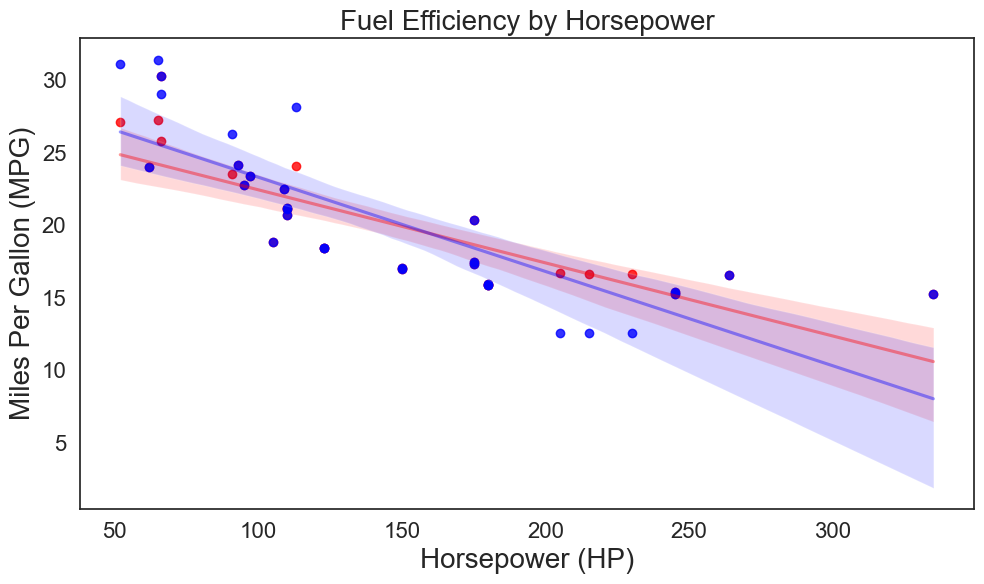

In [11]:

# Load original data
df_manipulated_r07 = pd.read_csv("My_mpg_manipulated_r07.csv")
df_manipulated = pd.read_csv("My_mpg_manipulated.csv")

features = ['hp', 'wt', 'disp', 'cyl']
target = 'mpg'

# Prepare features for prediction
X_manipulated = df_manipulated[features]
X_manipulated_r07 = df_manipulated_r07[features]  # Fixed typo here

# Load trained regression model
model = joblib.load("myRegressionmodelOriginal.pkl")

# Predict MPG using the model
predicted_mpg_manipulated = model.predict(X_manipulated)
predicted_mpg_manipulated_r07 = model.predict(X_manipulated_r07)

# Calculate and print correlation and p-values
r1, p1 = pearsonr(df_manipulated['hp'], predicted_mpg_manipulated)
r2, p2 = pearsonr(df_manipulated_r07['hp'], predicted_mpg_manipulated_r07)

print(f"Dataset: My_mpg_manipulated.csv")
print(f"  Correlation (r): {r1:.3f}")
print(f"  P-value: {p1:.5e}\n")

print(f"Dataset: My_mpg_manipulated_r07.csv")
print(f"  Correlation (r): {r2:.3f}")
print(f"  P-value: {p2:.5e}")

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="white")

# Plot predicted MPG from both datasets
sns.regplot(x=df_manipulated['hp'], y=predicted_mpg_manipulated, scatter=True, color='red', line_kws={'color': 'red', 'alpha': 0.4})
sns.regplot(x=df_manipulated_r07['hp'], y=predicted_mpg_manipulated_r07, scatter=True, color='blue', line_kws={'color': 'blue','alpha': 0.4})

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Horsepower (HP)", fontsize=20)
plt.ylabel("Miles Per Gallon (MPG)", fontsize=20)
plt.title("Fuel Efficiency by Horsepower", fontsize=20)

plt.tight_layout()
plt.show()


r: -0.833
P-value: 3.366e-09
[21.18874444 21.10207778 24.12737619 20.70399444 17.30648838 18.85956508
 15.37057251 23.97783333 22.77026667 18.42626508 18.42626508 15.94548203
 15.87118203 15.87118203 16.67308918 16.61618918 16.61618918 30.25491905
 27.11973333 27.27273333 23.36243333 17.06457172 16.94873838 15.2530114
 17.44991061 25.80823333 23.50786667 24.10206667 16.5683114  20.32931263
 15.2530114  22.48143333]
0     21.0
1     21.0
2     22.8
3     21.4
4     18.7
5     18.1
6     14.3
7     24.4
8     22.8
9     19.2
10    17.8
11    16.4
12    17.3
13    15.2
14    10.4
15    10.4
16    14.7
17    32.4
18    30.4
19    33.9
20    21.5
21    15.5
22    15.2
23    13.3
24    19.2
25    27.3
26    26.0
27    30.4
28    15.8
29    19.7
30    15.0
31    21.4
Name: mpg, dtype: float64


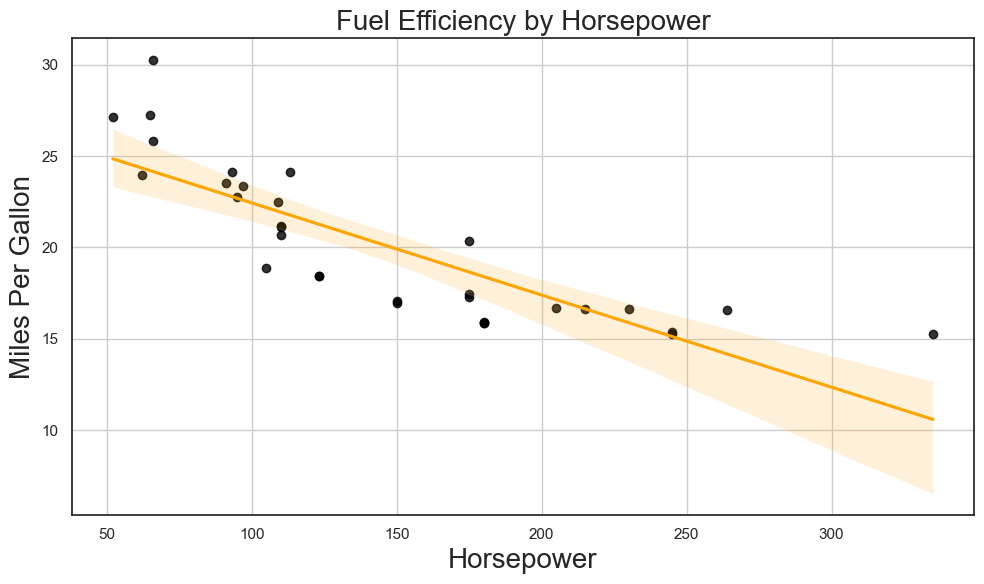

In [21]:

x = df_manipulated['hp']
y = y=predicted_mpg_manipulated

# Compute Pearson correlation and p-value
corr_coeff, p_value = pearsonr(x, y)
print(f"r: {corr_coeff:.3f}")
print(f"P-value: {p_value:.3e}")
print(y)
print(df_original[target])

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x=x, y=y, scatter_kws={'color': 'black'}, line_kws={'color': 'orange'})
plt.title("Fuel Efficiency by Horsepower", fontsize=20)
plt.xlabel("Horsepower", fontsize=20)
plt.ylabel("Miles Per Gallon", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()